In [21]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate
from qiskit.result import Result
from qiskit.primitives import SamplerResult
from qiskit_aer import AerSimulator

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt
import sys

import json
from qiskit_ibm_runtime import RuntimeDecoder

# 01 (Alice X Gate)

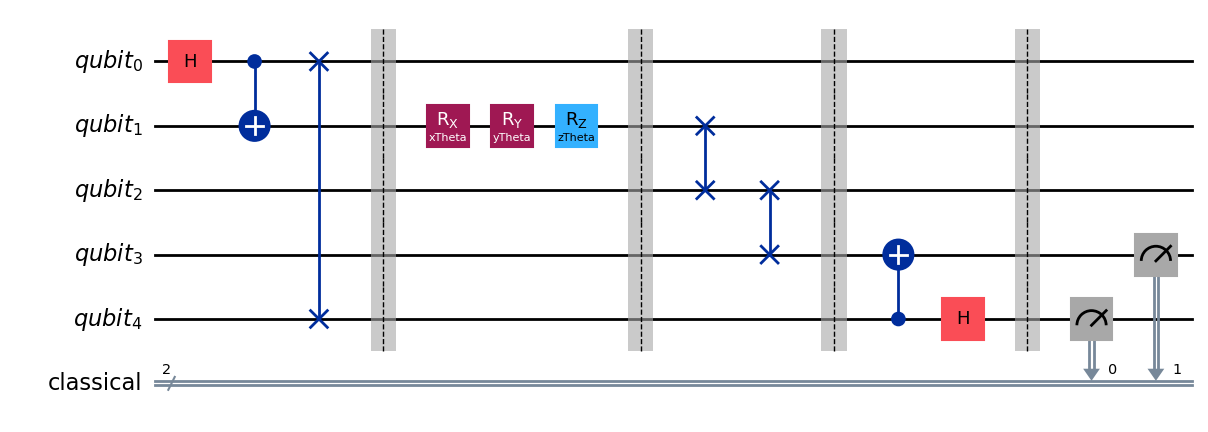

In [2]:
bNum = 2

xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')



num_data_qubits = bNum+3
num_data_cbits = 2

# Create qubit and classical data bit registers (you can create and name additional registers if it's useful for bookkeeping)
data_qubits = QuantumRegister(num_data_qubits, "qubit")
classical_data = ClassicalRegister(num_data_cbits, "classical")

# Create circuit object
qc = QuantumCircuit(data_qubits,  classical_data)

# Create empty lists to store qubits and classical bits for convenient access
qdata = []; cdata = []; 

# Store qubits from data_qubit register in list for convenient access
qdata[:] = data_qubits

# Store classical bits from classical_data register in list for convenient access
cdata[:] = classical_data
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.h(0) #This is state to be transported
qc.cx(0,1)
qc.swap(0,4)
qc.barrier()

# qc.id(1)
qc.rx(xTheta,1)
qc.ry(yTheta,1)
qc.rz(zTheta,1)
# qc.x(1)
# qc.z(1)
qc.barrier()

for i in range (1, bNum + 1):
    qc.swap(i, i+1)
qc.barrier()

qc.cx(bNum+2, bNum + 1)
qc.h(bNum+2)
qc.barrier()

qc.measure(bNum + 2, 0)
qc.measure(bNum + 1, 1)


qc.draw('mpl')

In [3]:

def send(bits2):
    params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    # if (bits2=='00'):
    #     params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='10'):
        params = {zTheta: 0,     yTheta: 0,     xTheta: pi}
    if (bits2 == '01'):
        params = {zTheta: pi,     yTheta: 0, xTheta: 0}
    if (bits2=='11'):
        params = {zTheta: pi, yTheta: 0,     xTheta: pi}
    return params
def send_string(bits):
    param_sets = []
    if (len(bits)%2==1):
        bits=f"{bits}0"
    for i in range(0,len(bits),2):
        bits2 = bits[i:i+2]
        param_sets.append(send(bits2))
    return param_sets
def bits_to_bytes(bit_string):
    if len(bit_string) % 8 != 0:
        bit_string = bit_string.ljust((len(bit_string) + 7) // 8 * 8, '0')
    byte_list = [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]
    return bytes(byte_list)



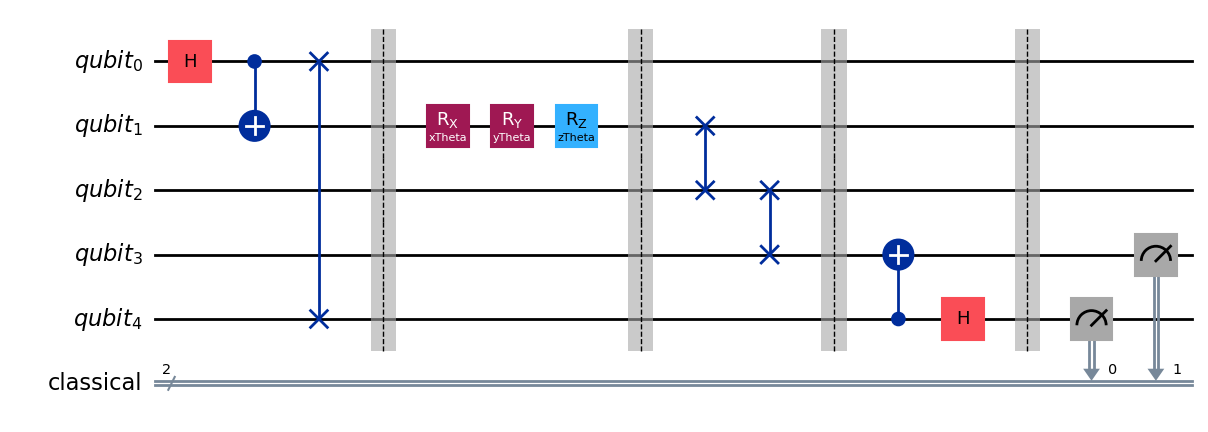

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
# backend = FakeSherbrooke()
backend = AerSimulator()
sampler = Sampler(backend)

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl')

## Test for a small string

In [5]:
param_sets = send_string("01101110010001010010")
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots = 1)
print(sys.getsizeof(job2))

56


In [41]:
def recieve_string(job):
    message = ""
    for i in range(len(job.result())):
        result = job.result()[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max = result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

def recieve_string_loaded_job(job):
    message = ""
    for i in range(len(job)):
        result = job[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max = result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

In [52]:
with open('tomb.jpg', 'rb') as file:
    file_content = file.read()
bit_string = ''.join(f'{byte:08b}' for byte in file_content)

with open('tomb.rgb', 'rb') as file:
    file_content = file.read()
rgb_bit_string = ''.join(f'{byte:08b}' for byte in file_content)

In [8]:
# from PIL import Image
# img = Image.open("tomb.jpg")
# pixels = list(img.getdata())
# pixel_string =  ''.join(str(num) for tup in pixels for num in tup)

In [9]:
param_sets = send_string(bit_string)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots=1)

# param_sets = send_string(rgb_bit_string)
# bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
# job2 = sampler.run(bound_circuits, shots=1)

KeyboardInterrupt: 

In [ ]:
file_path = "tombsent.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(recieve_string(job2)))
file.close()

file_path = "tombcheck.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(bit_string))
file.close()

byteerrors = 0
for original, sent in zip(bits_to_bytes(bit_string), bits_to_bytes(recieve_string(job2))):
    if original != sent:
        byteerrors += 1
print(f"byte errors: {byteerrors}")

biterrors = 0
for original, sent in zip(bit_string, recieve_string(job2)):
    if original != sent:
        biterrors += 1
print(f"bit errors: {biterrors}")
print(f"bit error rate: {biterrors / len(bit_string)}")

In [29]:
file_path = "rgbtombsent.rgb"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(recieve_string(job2)))
file.close()

file_path = "rgbtombcheck.rgb"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(rgb_bit_string))
file.close()

byteerrors = 0
for original, sent in zip(bits_to_bytes(rgb_bit_string), bits_to_bytes(recieve_string(job2))):
    if original != sent:
        byteerrors += 1
print(f"byte errors: {byteerrors}")

biterrors = 0
for original, sent in zip(rgb_bit_string, recieve_string(job2)):
    if original != sent:
        biterrors += 1
print(f"bit errors: {biterrors}")
print(f"bit error rate: {biterrors / len(bit_string)}")

byte errors: 1512
bit errors: 6147
bit error rate: 0.5045141168745896


## Setup and run at IBM

In [11]:
#Setup to send to the actual hardware
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='d0eb190d4a2030a50f46ce9ceb962e604fe8a5b75928d54117d32acbe12a6b942d981e1596fd9b689d78e7181d1f41f15ed80afc790acdb8effa7513bae38773'
)

#backend = FakeSherbrooke()
backend = service.backend("ibm_brisbane")

sampler = Sampler(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
# pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
# isa_circuit = pm.run(qc)
# isa_circuit.draw("mpl", idle_wires=False)

# param_sets = send_string(bit_string)
# bound_circuits = [isa_circuit.assign_parameters(param) for param in param_sets]
# job2 = sampler.run(bound_circuits, shots=10)

## 2 swaps, 1 shot, sherbrooke

In [ ]:
from qiskit_ibm_runtime.utils import RuntimeDecoder
import json job-d0wdzjevx7bg0081vr0g-result.json

In [60]:
with open('job-d0wdzjevx7bg0081vr0g-result.json') as f:
    result_data = json.load(f)

# Decode using Qiskit's RuntimeDecoder
retrieved_job = json.loads(json.dumps(result_data), cls=RuntimeDecoder)

file_path = "tombsent.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(recieve_string_loaded_job(retrieved_job)))
file.close()

file_path = "tombcheck.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(bit_string))
file.close()

byteerrors = 0
for original, sent in zip(bits_to_bytes(bit_string), bits_to_bytes(recieve_string_loaded_job(retrieved_job))):
    if original != sent:
        byteerrors += 1
print(f"byte errors: {byteerrors}")

biterrors = 0
for original, sent in zip(bit_string, recieve_string_loaded_job(retrieved_job)):
    if original != sent:
        biterrors += 1
print(f"bit errors: {biterrors}")
print(f"bit error rate: {biterrors / len(bit_string)}")

byte errors: 1514
bit errors: 6372
bit error rate: 0.5229809586342744


## 2 Swaps, 10 shots, brisbane

In [56]:
with open('job-d0we3hyhtw7g008pynm0-result.json') as f:
    result_data = json.load(f)

# Decode using Qiskit's RuntimeDecoder
retrieved_job = json.loads(json.dumps(result_data), cls=RuntimeDecoder)

file_path = "tombsent.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(recieve_string_loaded_job(retrieved_job)))
file.close()

file_path = "tombcheck.jpg"
file = open(file_path, "bw")  # Open in write mode
file.write(bits_to_bytes(bit_string))
file.close()

byteerrors = 0
for original, sent in zip(bits_to_bytes(bit_string), bits_to_bytes(recieve_string_loaded_job(retrieved_job))):
    if original != sent:
        byteerrors += 1
print(f"byte errors: {byteerrors}")

biterrors = 0
for original, sent in zip(bit_string, recieve_string_loaded_job(retrieved_job)):
    if original != sent:
        biterrors += 1
print(f"bit errors: {biterrors}")
print(f"bit error rate: {biterrors / len(bit_string)}")

byte errors: 605
bit errors: 811
bit error rate: 0.06656270518713066


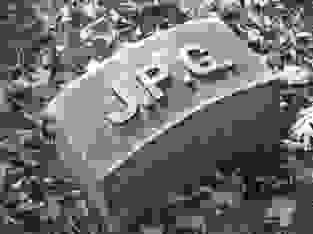

[[ 64  64  64 ...  64  64  59]
 [ 64  64  64 ...  64  64 105]
 [ 64  64  64 ...  64  64 140]
 ...
 [ 64  64  64 ...  64  64  64]
 [ 64  64  64 ...  64  64  64]
 [ 64  64  64 ...  64  64  64]]


In [66]:
from PIL import Image
img = Image.open("tomb.jpg")
img_gray = img.convert('L')
pixels = list(img.getdata())
pixel_string =  ''.join(str(num) for tup in pixels for num in tup)
display(img_gray)
print(np.array(img_gray))